In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
import pandas as pd
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import sys

In [11]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = "train/"
TEST_PATH = "validation/"

warnings.filterwarnings('ignore', category= UserWarning, module = 'skimage')
seed = 42
random.seed = seed
np.random.seed = seed

 ### Collect out file names for training and testing

In [12]:
train_ids  = next(os.walk(TRAIN_PATH))[1]
test_ids  = next(os.walk(TEST_PATH))[1]
#print(test_ids)

### Creating our image masks of dimension 128 * 128(black images)

In [13]:
print("Getting and resizing training images ...")
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
print(X_train.shape)
#resizing out training imges to 128 * 128
#Note sys.stdout prints info that can be cleared unlike print
#using TQDM allows us to create progress bars

sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + "/images/" + id_ + '.png')[:, :, :IMG_CHANNELS]
    #print(img.shape)
    #print(n)
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    #print(img.shape)
    X_train[n] = img
    #print(n)
    
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH ,1),  dtype = np.bool)
    
    # now we take all masks associated with that image and combine them into one single mask
    for mask_file in next(os.walk(path + "/masks/"))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', 
                                     preserve_range =True), axis = -1)
        
        mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        
    # Y_train is now our single mask associated with our image

    
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype= np.uint8)
size_test = []
print("Getting and resizing test images ...")
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + "/images/" + id_ + '.png')[:, :, :IMG_CHANNELS]
    size_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    #print(img.shape)
    X_test[n] = img
    #mask = np.zeros((IMG_HEIGHT, IMG_WIDTH ,1),  dtype = np.bool)
print("Done")

Getting and resizing training images ...
(670, 128, 128, 3)


100%|██████████| 670/670 [04:07<00:00,  1.18it/s]

Getting and resizing test images ...



100%|██████████| 65/65 [00:02<00:00, 29.88it/s]

Done


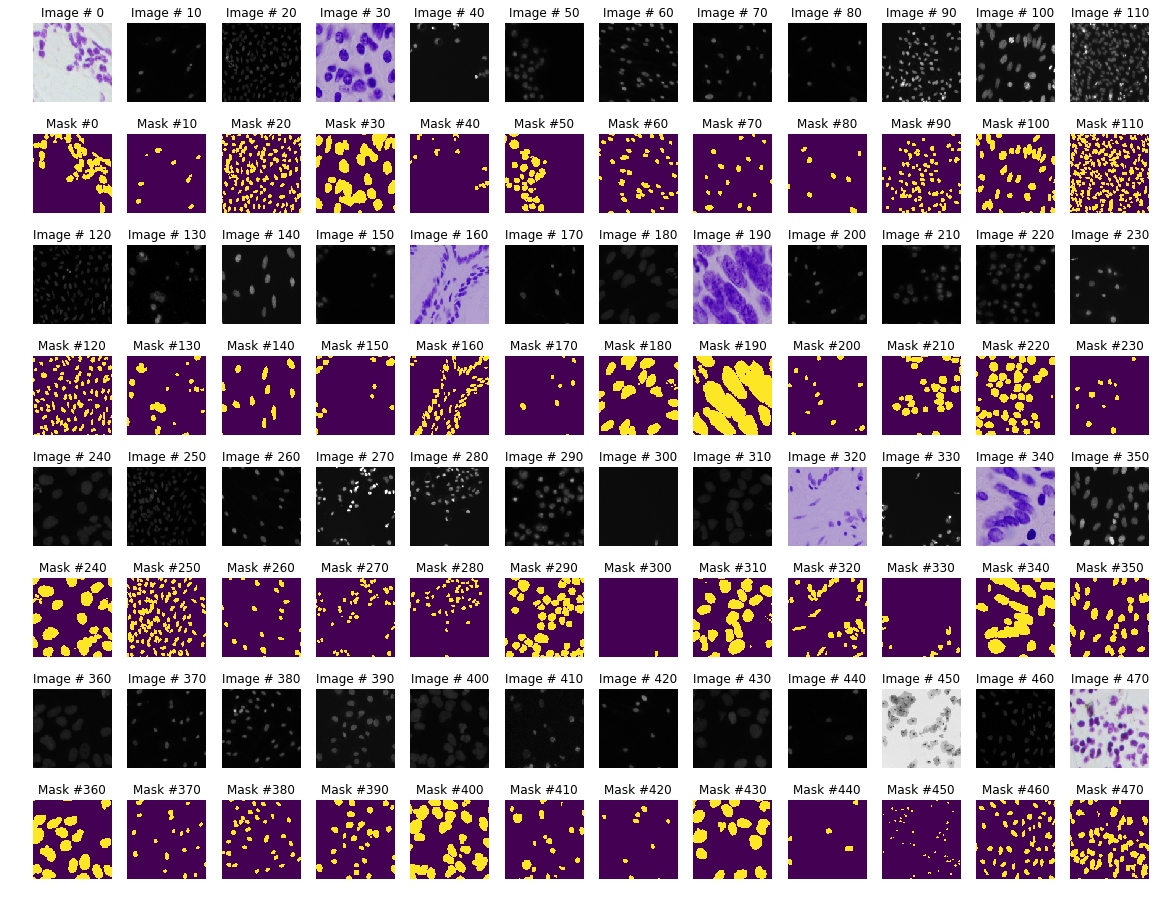

In [14]:
#illustrate the train images and mask

plt.figure(figsize = (20, 16))
x, y = 12, 4
for i in range(y):
    for j in range(x):
        plt.subplot(y*2,  x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image # {}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associate mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()
        

### We define a custom metric calles Intersection over Union(IoU)


In [15]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred = tf.to_int32(y_pred>t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
        
    return K.mean(K.stack(prec), axis=0)
        
    

In [16]:
def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred > 0], tf.float32)
    return metric_value


def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype =  np.float32)


def iou_metric(y_true, y_pred_in, print_table = False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins = (true_objects, pred_objects))[0]
    
    #computer areas (needed for finding the union between all objects)

    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    
    #computer union
    union = area_true + area_pred - intersection
    
    #Exclude backgroud from the analysis
    
    intersection = intersection[1:, 1:]
    union = union[1:, 1:]
    union[union==0] = 1e-9
    
    #Compute the intersection over union
    iou = intersection / union
    
    def precision_at(threshold, iou):
        matches =  iou>threshold
        true_positives = np.sum(matches, axis = 1)==1      #Correct objects
        false_positives = np.sum(matches, axis = 0)==0     #missed objects
        false_negatives = np.sum(matches, axis = 1)==0     #extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        
        return tp, fp, fn
    
    #Loop over IoU thresholds
    
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if(tp+fp+fn) > 0:
            p = tp/ (tp+fp+fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
        
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    
    return np.mean(prec)
        
        
         
    

In [17]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    print(A.shape)
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

In [18]:
def my_iou_metric3(label, pred):
    return tf.py_func(iou_metric_batch3, [label, pred>0.5], tf.float64)


def iou_metric3(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    
    # Compute union
    union = area_true + area_pred - intersection
      
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn
    
    
     # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch3(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric3(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

### Building our U-net model

In [19]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS))
s = Lambda(lambda x: x/255)(inputs)

c1 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c1)
p1 = MaxPooling2D((2,2))(c1)


c2 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = MaxPooling2D((2,2))(c2)


c3 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = MaxPooling2D((2,2))(c3)


c4 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = MaxPooling2D((2,2))(c4)



c5 = Conv2D(256, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c5)


u6 = Conv2DTranspose(128, (2, 2), strides = (2,2), padding = 'same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c6)


u7 = Conv2DTranspose(64, (2, 2), strides = (2,2), padding = 'same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c7)


u8 = Conv2DTranspose(32, (2, 2), strides = (2,2), padding = 'same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c8)


u9 = Conv2DTranspose(16, (2, 2), strides = (2,2), padding = 'same')(c8)
u9 = concatenate([u9, c1], axis = 3)
c9 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c9)

outputs = Conv2D(1, (1,1), activation = 'sigmoid')(c9)

#print(outputs.shape)
model = Model(inputs= [inputs], outputs = [outputs])
model.compile(optimizer= 'adam' , loss = 'binary_crossentropy', metrics = [my_iou_metric3])
model.summary()




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 128, 128, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

### Fir our model 

In [20]:
#initialize our callbacks
model_path = "model.h5"
checkpoint= ModelCheckpoint(model_path,
                           monitor= "val_loss",
                           mode = "min", 
                           save_best_only = True, 
                           verbose = 1)


earlystop = EarlyStopping(monitor = "val_loss", 
                         min_delta = 0, 
                         patience = 5, 
                         verbose = 1, 
                         restore_best_weights = True)
results = model.fit(X_train, Y_train, validation_split = 0.1, 
                   batch_size = 16, epochs = 5, 
                   callbacks = [earlystop, checkpoint])

Train on 603 samples, validate on 67 samples
Epoch 1/5


/home/dheeraj/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


603/603 [==============================] - 157s 260ms/step - loss: 0.3459 - my_iou_metric3: 0.1035 - val_loss: 0.1757 - val_my_iou_metric3: 0.2194

Epoch 00001: val_loss improved from inf to 0.17572, saving model to model.h5
Epoch 2/5
603/603 [==============================] - 153s 254ms/step - loss: 0.1673 - my_iou_metric3: 0.3312 - val_loss: 0.1412 - val_my_iou_metric3: 0.3836

Epoch 00002: val_loss improved from 0.17572 to 0.14125, saving model to model.h5
Epoch 3/5
603/603 [==============================] - 159s 264ms/step - loss: 0.1258 - my_iou_metric3: 0.4960 - val_loss: 0.1707 - val_my_iou_metric3: 0.4597

Epoch 00003: val_loss did not improve from 0.14125
Epoch 4/5
603/603 [==============================] - 153s 254ms/step - loss: 0.1205 - my_iou_metric3: 0.5542 - val_loss: 0.1244 - val_my_iou_metric3: 0.4836

Epoch 00004: val_loss improved from 0.14125 to 0.12444, saving model to model.h5
Epoch 5/5
603/603 [==============================] - 167s 278ms/step - loss: 0.1078 - my

In [21]:
#Predict on training and validation data
# Note our use of mean_iou metric
model = load_model('model.h5', custom_objects = {'my_iou_metric3' : my_iou_metric3})

print(X_train.shape)
#The first 90% was used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)

#The last 10% used for validation
preds_val =   model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)


#preds_test = model.predict(X_test, verbose = 1)

#threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)



(670, 128, 128, 3)
67/67 [==============================] - 4s 62ms/step


In [22]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

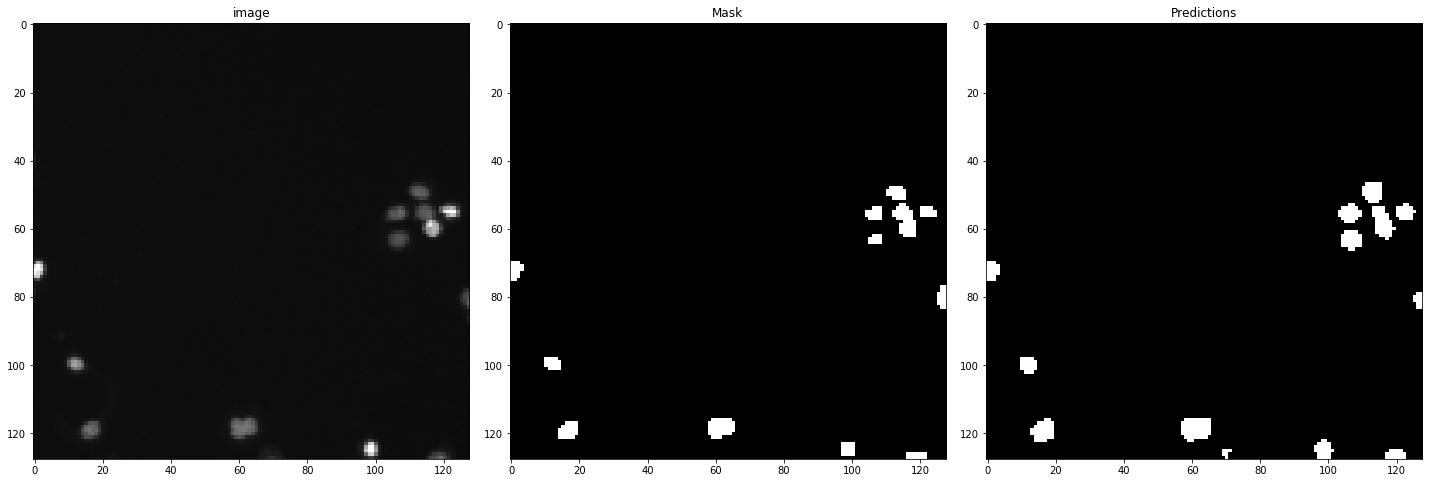

In [23]:
#Plotting out predicted masks
ix = random.randint(0, 602)
plt.figure(figsize = (20, 20))

#Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("image")

#Our original combine mask
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix]> 0.5))
plt.title("Predictions")

plt.show()



### Showing predicted masks on validation data


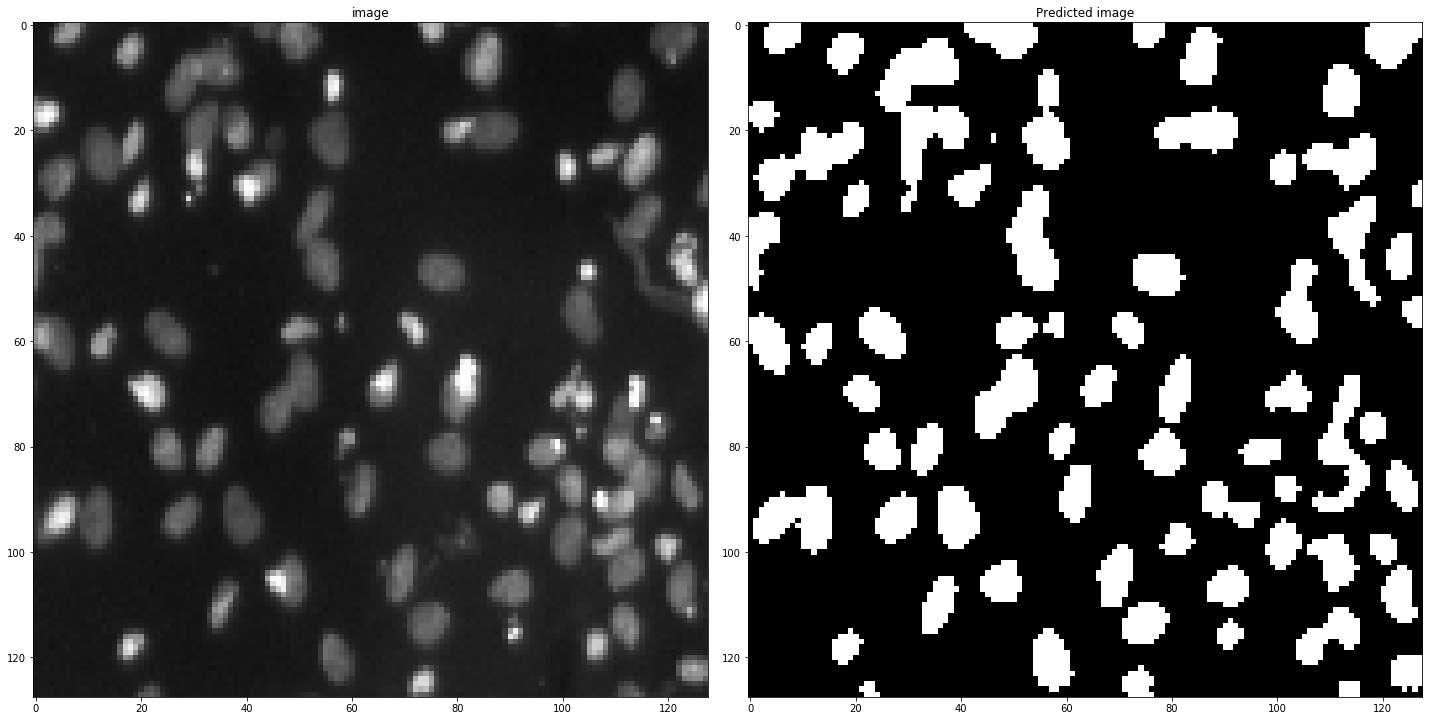

In [27]:
#Plotting predicted masks
ix = random.randint(602, 668)
plt.figure(figsize = (20, 20))

#Original Training image
plt.subplot(121)
imshow(X_train[ix])
plt.title('image')

#Mask the U-Net model predicts
plt.subplot(122)
ix = ix- 603

imshow(np.squeeze(preds_val_t[ix] > 0.5))
plt.title('Predicted image')
plt.show()